### Extracting outliers from UKB dMRI parameters

In [1]:
%matplotlib inline
import os
import sys
import csv
import pickle
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.colors
import collections
import seaborn as sns
import statistics
ukb_root = '/project_freenas/3022017.02/UKB'
homedir = '/home/preclineu/ramcir/Desktop/Diffusion/diffusion_nm'
sys.path.append(os.path.join(ukb_root,'scripts'))
from ukb_utils import get_variables_UKB, lookup_UKB
ukb_idp_dir = os.path.join(ukb_root,'phenotypes','current')

### Load Data

In [2]:
outlier_subs = []

In [3]:
### Read dMRI data of available participants
train_data = '/home/preclineu/ramcir/Desktop/Diffusion/diffusion_nm/df_tr.pkl'
test_data = '/home/preclineu/ramcir/Desktop/Diffusion/diffusion_nm/df_te.pkl'
with open(train_data, 'rb') as f: 
    data_train = pickle.load(f)
    data_train = data_train.astype('float64')
with open(test_data, 'rb') as f: 
    data_test = pickle.load(f)
    data_test = data_test.astype('float64')    
data = pd.concat([data_train,data_test])  

In [4]:
data

,sex,site,age,Mean_FA_in_body_of_corpus_callosum_on_FA_skeleton,Mean_FA_in_fornix_on_FA_skeleton,Mean_FA_in_corticospinal_tract_on_FA_skeleton_right,Mean_FA_in_corticospinal_tract_on_FA_skeleton_left,Mean_FA_in_uncinate_fasciculus_on_FA_skeleton_right,Mean_FA_in_uncinate_fasciculus_on_FA_skeleton_left,Mean_MD_in_body_of_corpus_callosum_on_FA_skeleton,...,Mean_ICVF_in_corticospinal_tract_on_FA_skeleton_right,Mean_ICVF_in_corticospinal_tract_on_FA_skeleton_left,Mean_ICVF_in_uncinate_fasciculus_on_FA_skeleton_right,Mean_ICVF_in_uncinate_fasciculus_on_FA_skeleton_left,Mean_ISOVF_in_body_of_corpus_callosum_on_FA_skeleton,Mean_ISOVF_in_fornix_on_FA_skeleton,Mean_ISOVF_in_corticospinal_tract_on_FA_skeleton_right,Mean_ISOVF_in_corticospinal_tract_on_FA_skeleton_left,Mean_ISOVF_in_uncinate_fasciculus_on_FA_skeleton_right,Mean_ISOVF_in_uncinate_fasciculus_on_FA_skeleton_left
eid,,,,,,,,,,,,,,,,,,,,,
1000432,1.0,11027.0,70.0,0.756112,0.425457,0.518805,0.511370,0.543840,0.517835,0.739,...,0.721853,0.703444,0.535655,0.561188,0.086779,0.451599,0.181647,0.253500,0.020406,0.020654
1000853,0.0,11025.0,73.0,0.713533,0.203436,0.491433,0.513559,0.554120,0.472923,0.815,...,0.637163,0.615584,0.498758,0.470336,0.114360,0.888771,0.110728,0.134515,0.019304,0.040751
1000871,1.0,11027.0,73.0,0.703294,0.361442,0.511651,0.518568,0.484445,0.516493,0.830,...,0.647888,0.627111,0.484254,0.502732,0.148352,0.656673,0.173913,0.143994,0.016760,0.022428
1000910,0.0,11025.0,69.0,0.692061,0.305917,0.483183,0.487560,0.506470,0.471372,0.814,...,0.716698,0.716548,0.507131,0.491213,0.147347,0.711313,0.185124,0.160826,0.021615,0.013512
1001309,1.0,11027.0,76.0,0.669036,0.382439,0.531169,0.570457,0.532362,0.508725,0.855,...,0.673238,0.697223,0.474699,0.467378,0.132345,0.651564,0.161821,0.169396,0.016089,0.013889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6022149,1.0,11025.0,67.0,0.701434,0.353598,0.509876,0.544145,0.547670,0.466851,0.781,...,0.757687,0.716837,0.536816,0.510246,0.081786,0.653735,0.115980,0.145802,0.002361,0.011285
6023174,0.0,11025.0,69.0,0.681440,0.360224,0.465836,0.503520,0.538687,0.518593,0.857,...,0.667827,0.699188,0.480915,0.482518,0.122247,0.596491,0.151459,0.159231,0.005372,0.010902
6023696,1.0,11025.0,69.0,0.746134,0.426707,0.566514,0.582231,0.542170,0.556581,0.771,...,0.738869,0.768217,0.513055,0.519368,0.103257,0.578402,0.137889,0.153698,0.022794,0.016237


In [5]:
# Load qc measurements dataframe
save_path = os.path.join(homedir,'outliers_params.pkl')
outliers_params = pd.read_pickle(save_path)

In [6]:
## Determine IDPs to be analyzed 
idp_ids = ['Mean_FA_in_body_of_corpus_callosum_on_FA_skeleton', 
           'Mean_FA_in_uncinate_fasciculus_on_FA_skeleton_left',
           'Mean_FA_in_uncinate_fasciculus_on_FA_skeleton_right',
           'Mean_FA_in_fornix_on_FA_skeleton',
           'Mean_FA_in_corticospinal_tract_on_FA_skeleton_left',
           'Mean_FA_in_corticospinal_tract_on_FA_skeleton_right',
           'Mean_MD_in_body_of_corpus_callosum_on_FA_skeleton', 
           'Mean_MD_in_uncinate_fasciculus_on_FA_skeleton_left',
           'Mean_MD_in_uncinate_fasciculus_on_FA_skeleton_right',
           'Mean_MD_in_fornix_on_FA_skeleton',
           'Mean_MD_in_corticospinal_tract_on_FA_skeleton_left',  
           'Mean_MD_in_corticospinal_tract_on_FA_skeleton_right',
           'Mean_ICVF_in_body_of_corpus_callosum_on_FA_skeleton', 
           'Mean_ICVF_in_uncinate_fasciculus_on_FA_skeleton_left',
           'Mean_ICVF_in_uncinate_fasciculus_on_FA_skeleton_right',
           'Mean_ICVF_in_fornix_on_FA_skeleton',
           'Mean_ICVF_in_corticospinal_tract_on_FA_skeleton_left',
           'Mean_ICVF_in_corticospinal_tract_on_FA_skeleton_right',
           'Mean_ISOVF_in_body_of_corpus_callosum_on_FA_skeleton', 
           'Mean_ISOVF_in_uncinate_fasciculus_on_FA_skeleton_left',
           'Mean_ISOVF_in_uncinate_fasciculus_on_FA_skeleton_right',
           'Mean_ISOVF_in_fornix_on_FA_skeleton',
           'Mean_ISOVF_in_corticospinal_tract_on_FA_skeleton_left',
           'Mean_ISOVF_in_corticospinal_tract_on_FA_skeleton_right']

# idp_ids = ['Mean_ISOVF_in_uncinate_fasciculus_on_FA_skeleton_left']

# idp_ids_short = ['ISOVF_uncinate_left'] 

idp_ids_short = ['FA_corpus_callosum', 
               'FA_uncinate_left',
               'FA_uncinate_right',
               'FA_fornix',
               'FA_corticospinal_left',
               'FA_corticospinal_right',
               'MD_corpus_callosum', 
               'MD_uncinate_left',
               'MD_uncinate_right',
               'MD_fornix',
               'MD_corticospinal_left', 
               'MD_corticospinal_right',
               'ICVF_corpus_callosum', 
               'ICVF_uncinate_left',
               'ICVF_uncinate_right',
               'ICVF_fornix',
               'ICVF_corticospinal_left',
               'ICVF_corticospinal_right',
               'ISOVF_corpus_callosum', 
               'ISOVF_uncinate_left',
               'ISOVF_uncinate_right',
               'ISOVF_fornix',
               'ISOVF_corticospinal_left',
               'ISOVF_corticospinal_right']

df_idp_outliers = pd.DataFrame(0, index=outliers_params.index, columns=idp_ids_short)

In [7]:
for idp, idp_short in zip(idp_ids, idp_ids_short):
#     print(idp)
    # Read Z-scores of available participants
    z_path_train = os.path.join(homedir,'braincharts','models', 'test', idp, 'Z_training.txt')
    z_path_test = os.path.join(homedir,'braincharts','models', 'test', idp, 'Z_estimate.txt')
    data_train = [float(number)
            for line in open(z_path_train, 'r')
            for number in line.split()]
    data_test = [float(number)
            for line in open(z_path_test, 'r')
            for number in line.split()]
    z_scores_train = pd.DataFrame(data_train, columns =['z_scores'])
    z_scores_test = pd.DataFrame(data_test, columns =['z_scores'])
    z_scores = pd.concat([z_scores_train,z_scores_test])  

    # Assign the right participant ID to the right z-score
    z_scores.index = data.index

    
    #### Select outliers #####
    # threshold z-values 
    threshold1 = np.logical_or(z_scores>int(z_scores.mean(axis=0)+7*np.std(z_scores)), z_scores<int(z_scores.mean(axis=0)-7*np.std(z_scores)))
    th_z_scores = z_scores.copy(deep=True)
    th_z_scores = z_scores[threshold1]
    th_z_scores.dropna(inplace=True)
    print(len(th_z_scores), 'outliers for threshold z = +-', int(z_scores.mean(axis=0)+7*np.std(z_scores)), 'in', idp_short)

    # save subs id list
    th_subs = th_z_scores.index
#     save_path = os.path.join(homedir,'ukb_outliers', idp)
#     with open(save_path, 'w') as f:
#         for line in th_subs:
#             f.write(line)
#             f.write('\n')
    for line in th_subs:
        outlier_subs.append(line)
        df_idp_outliers.at[line, idp_short] = 1    


6 outliers for threshold z = +- 6 in FA_corpus_callosum
4 outliers for threshold z = +- 6 in FA_uncinate_left
5 outliers for threshold z = +- 6 in FA_uncinate_right
0 outliers for threshold z = +- 6 in FA_fornix
5 outliers for threshold z = +- 6 in FA_corticospinal_left
3 outliers for threshold z = +- 6 in FA_corticospinal_right
19 outliers for threshold z = +- 6 in MD_corpus_callosum
17 outliers for threshold z = +- 6 in MD_uncinate_left
18 outliers for threshold z = +- 6 in MD_uncinate_right
1 outliers for threshold z = +- 6 in MD_fornix
9 outliers for threshold z = +- 6 in MD_corticospinal_left
10 outliers for threshold z = +- 6 in MD_corticospinal_right
26 outliers for threshold z = +- 6 in ICVF_corpus_callosum
28 outliers for threshold z = +- 6 in ICVF_uncinate_left
24 outliers for threshold z = +- 6 in ICVF_uncinate_right
19 outliers for threshold z = +- 6 in ICVF_fornix
27 outliers for threshold z = +- 6 in ICVF_corticospinal_left
27 outliers for threshold z = +- 6 in ICVF_corti

<function matplotlib.pyplot.show(close=None, block=None)>

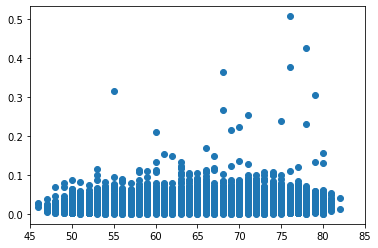

In [8]:
plt.scatter(data.age,data.Mean_ISOVF_in_uncinate_fasciculus_on_FA_skeleton_left)
plt.xlim((45,85))
# plt.ylim((np.mean(z_scores.z_scores)-20*np.std(z_scores.z_scores)), (np.mean(z_scores.z_scores)+20*np.std(z_scores.z_scores)))
plt.show

In [9]:
print("mean:", data.Mean_ISOVF_in_uncinate_fasciculus_on_FA_skeleton_left.mean())
print("max:", data.Mean_ISOVF_in_uncinate_fasciculus_on_FA_skeleton_left.max())
print("min:", data.Mean_ISOVF_in_uncinate_fasciculus_on_FA_skeleton_left.min())
print("std:", data.Mean_ISOVF_in_uncinate_fasciculus_on_FA_skeleton_left.std())

mean: 0.02009437136929443
max: 0.507419
min: 0.0
std: 0.015061097361462567


In [10]:
print("mean:", z_scores["z_scores"].mean())
print("max:", z_scores["z_scores"].max())
print("min:", z_scores["z_scores"].min())
print("std:", z_scores["z_scores"].std())

mean: -0.001822885410187878
max: 8.886842409887088
min: -2.484180507145548
std: 0.9147346348748495


In [18]:
df_idp_outliers = df_idp_outliers.fillna(0)
df_idp_outliers
save_path = '/home/preclineu/ramcir/Desktop/Diffusion/diffusion_nm/outliers_idp_type.pkl'
df_idp_outliers.to_pickle(save_path)

In [17]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(df_idp_outliers)

,FA_corpus_callosum,FA_uncinate_left,FA_uncinate_right,FA_fornix,FA_corticospinal_left,FA_corticospinal_right,MD_corpus_callosum,MD_uncinate_left,MD_uncinate_right,MD_fornix,MD_corticospinal_left,MD_corticospinal_right,ICVF_corpus_callosum,ICVF_uncinate_left,ICVF_uncinate_right,ICVF_fornix,ICVF_corticospinal_left,ICVF_corticospinal_right,ISOVF_corpus_callosum,ISOVF_uncinate_left,ISOVF_uncinate_right,ISOVF_fornix,ISOVF_corticospinal_left,ISOVF_corticospinal_right
eid,,,,,,,,,,,,,,,,,,,,,,,,
1326726,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4075948,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5901699,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4663332,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
6005432,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
5310085,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
2792426,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
4371954,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
2230888,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0


### Calculate the frequency of outliers across IDPs

In [13]:
freq = collections.Counter(outlier_subs)
freq_outliers = pd.DataFrame.from_dict(freq, orient='index').reset_index()
freq_outliers.columns = ['eid', 'frequency']
freq_outliers = freq_outliers.set_index('eid')
freq_outliers = freq_outliers.sort_values(by='frequency', ascending=False)

print('There are', len(outlier_subs), 'outliers in total across all IDPs')
print('There are', sum(i > 1 for i in freq_outliers["frequency"]), 'subjects who are outliers in more than one IDP')
print('There are', len(freq_outliers), 'unique outliers across all IDPs')

There are 311 outliers in total across all IDPs
There are 50 subjects who are outliers in more than one IDP
There are 85 unique outliers across all IDPs


In [ ]:
# Save list of outliers
# outlier_list = freq_outliers.index.to_numpy
# save_path = save_path = os.path.join(homedir,'ukb_outliers', 'outlier_list')
# np.save(save_path, outlier_list, allow_pickle=True)

In [ ]:
# Load qc measurements dataframe
save_path = os.path.join(homedir,'outliers_params.pkl')
outliers_params = pd.read_pickle(save_path)
freq_outliers = freq_outliers.filter(items = outliers_params.index, axis=0)
outlier_data = outliers_params.join(freq_outliers)

In [ ]:
# outlier_data = outliers_params.join(freq_outliers)

In [7]:
outlier_data

NameError: name 'outlier_data' is not defined

In [8]:
# save_path = os.path.join(homedir,'outliers_data.pkl')
# outlier_data.to_pickle(save_path)

### Calculate threshold for QC measurements

In [9]:
save_path = '/home/preclineu/ramcir/Desktop/Diffusion/diffusion_nm/500ukb_qcfeatures.pkl'
data_qc = pd.read_pickle(save_path)

In [10]:
data_qc

,Avg_x_tr,Avg_y_tr,Avg_z_tr,Avg_x_rot,Avg_y_rot,Avg_z_rot,Std_EC_x,Std_EC_y,Std_EC_z,Outliers_b1000,Outliers_b1997,Outliers_PE_dir,Avg_abs_motion,Avg_rel_motion,Total_outliers,T1_discrep,No_outliers_corrected,SNR,FA_qc
ID,,,,,,,,,,,,,,,,,,,
1012530,0.153069,0.520014,0.682749,-0.007641,-0.000119,0.003507,0.076066,0.106307,0.275681,1.472222,0.611111,0.992063,1.08,0.61,1.041667,0.531493,75.0,25.659870,0.181719
1013160,-0.165238,-0.3517,0.186249,-0.001486,0.004002,0.000625,0.106745,0.116903,0.380474,2.416667,0.361111,1.322751,1.16,1.34,1.388889,0.505458,100.0,29.437838,0.183606
1013741,0.45744,-0.70807,0.086299,0.000962,-0.00158,0.006458,0.092471,0.104181,0.202555,0.944444,0.0,0.449735,2.15,2.25,0.472222,0.536674,34.0,20.916178,0.205814
1013898,0.005219,-0.659875,0.26501,-0.000304,0.00788,-0.001478,0.123468,0.310896,0.312134,1.5,0.055556,0.740741,1.79,2.08,0.777778,0.551897,56.0,25.744822,0.160316
1034202,0.062231,-0.23984,0.382442,0.001354,0.002757,0.003498,0.067464,0.096926,0.157097,0.555556,0.0,0.26455,1.52,1.61,0.277778,0.538646,20.0,21.464127,0.198774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5843972,-0.079535,-0.108484,-0.118731,0.000641,0.000868,-0.001685,0.055055,0.04529,0.216673,0.666667,0.055556,0.343915,0.79,1.07,0.361111,0.573463,26.0,30.558315,0.227340
5865349,0.502095,-0.579716,-0.171351,0.001372,-0.001943,0.00744,0.113306,0.122532,0.302943,0.527778,0.0,0.251323,1.05,0.95,0.263889,0.556037,19.0,27.987095,0.226276
5888895,0.068543,-0.196352,0.226279,-0.005492,0.001236,0.00009,0.103048,0.229723,0.232113,0.416667,0.0,0.198413,0.69,0.69,0.208333,0.429846,15.0,29.640865,0.189544


In [35]:
print('Threshold SNR: ', int(data_qc['SNR'].mean(axis=0)+2*np.std(data_qc['SNR'])))
print('Threshold T1 discrep: ', data_qc['T1_discrep'].mean(axis=0)+2*np.std(data_qc['T1_discrep']))
print('Threshold Slices dropped: ', int(data_qc['No_outliers_corrected'].mean(axis=0)+2*np.std(data_qc['No_outliers_corrected'])))
print('Threshold FA discrep: ', data_qc['FA_qc'].mean(axis=0)+2*np.std(data_qc['FA_qc']))

Threshold SNR:  36
Threshold T1 discrep:  0.7133935227243603
Threshold Slices dropped:  108
Threshold FA discrep:  0.2405165563326874


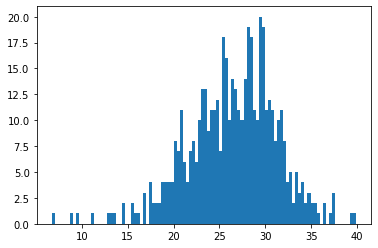

In [36]:
plt.hist(data_qc['SNR'],bins=100)
plt.show()

### Count atypicalities detected in each outlier

In [37]:
outlier_data['SNR'] = outlier_data['SNR'].astype(float)
outlier_data['FA_discrep'] = outlier_data['FA_discrep'].astype(float)

outlier_data.loc[outlier_data['T1_discrep']>=data_qc['T1_discrep'].mean(axis=0)+2*np.std(data_qc['T1_discrep']), 'T1_discrep_outlier'] = 1
outlier_data.loc[outlier_data['T1_discrep']<data_qc['T1_discrep'].mean(axis=0)+2*np.std(data_qc['T1_discrep']), 'T1_discrep_outlier'] = 0

outlier_data.loc[outlier_data['SNR']>=data_qc['SNR'].mean(axis=0)+2*np.std(data_qc['SNR']), 'SNR_outlier'] = 1
outlier_data.loc[outlier_data['SNR']<data_qc['SNR'].mean(axis=0)+2*np.std(data_qc['SNR']), 'SNR_outlier'] = 0

outlier_data.loc[outlier_data['Total_outliers']>=data_qc['No_outliers_corrected'].mean(axis=0)+2*np.std(data_qc['No_outliers_corrected']), 'Total_outliers_outlier'] = 1
outlier_data.loc[outlier_data['Total_outliers']<data_qc['No_outliers_corrected'].mean(axis=0)+2*np.std(data_qc['No_outliers_corrected']), 'Total_outliers_outlier'] = 0

outlier_data.loc[outlier_data['FA_discrep']>=data_qc['FA_qc'].mean(axis=0)+2*np.std(data_qc['FA_qc']), 'FA_discrep_outlier'] = 1
outlier_data.loc[outlier_data['FA_discrep']<data_qc['FA_qc'].mean(axis=0)+2*np.std(data_qc['FA_qc']), 'FA_discrep_outlier'] = 0

In [38]:
outlier_data

,sex,age,T1_discrep,Total_outliers,FA_discrep,SNR,frequency,T1_discrep_outlier,SNR_outlier,Total_outliers_outlier,FA_discrep_outlier
eid,,,,,,,,,,,
1326726,1.0,56.0,0.950575,242.0,0.860961,30.431709,11,1.0,0.0,1.0,1.0
4075948,0.0,55.0,0.960339,274.0,0.815509,31.991095,11,1.0,0.0,1.0,1.0
5901699,1.0,80.0,0.966959,356.0,0.538933,11.020597,11,1.0,0.0,1.0,1.0
4663332,0.0,63.0,0.827152,0.0,0.478117,3.931540,10,1.0,0.0,0.0,1.0
6005432,0.0,79.0,0.845704,42.0,0.612342,4.944144,10,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
4998292,1.0,68.0,0.591851,41.0,0.211864,19.168098,1,0.0,0.0,0.0,0.0
1561680,0.0,73.0,0.510018,14.0,0.225809,29.917219,1,0.0,0.0,0.0,0.0
1829475,0.0,73.0,0.464139,106.0,0.214403,23.408358,1,0.0,0.0,0.0,0.0


In [39]:
save_path = os.path.join(homedir,'outliers_data_count.csv')
outlier_data.to_csv(save_path)

### Visualize scans of outliers

In [40]:
string = ""

#this is where the slicesdir will be saved
os.chdir(qcdir)

#append the path to b0_data and brain mask for each sub
for s in sub_complete[0:]:
    dmridir = os.path.join(s, 'dMRI', 'dMRI')
    string+=str(dmridir + '/b0_average.nii.gz ' + dmridir + '/b0_average_brain_mask.nii.gz' + ' ')

#prep and run the slicesdir command
slices_cmd = 'slicesdir'
prep_cmd = slices_cmd + ' -o ' + string
subprocess.run(prep_cmd, shell = True)

NameError: name 'qcdir' is not defined

### Add QC scores for outliers

In [41]:
save_path = '/home/preclineu/ramcir/Desktop/Diffusion/diffusion_nm/qcscoresoutlers.csv'
outliers_qcscores = pd.read_csv(save_path)
outlier_data = outlier_data.join(outliers_qcscores.set_index(outlier_data.index), on='eid',how='left')
outlier_data['number_atyp'] = outlier_data[["T1_discrep_outlier", "SNR_outlier", "Total_outliers_outlier", "FA_discrep_outlier"]].sum(axis=1)

In [42]:
outlier_data

,sex,age,T1_discrep,Total_outliers,FA_discrep,SNR,frequency,T1_discrep_outlier,SNR_outlier,Total_outliers_outlier,FA_discrep_outlier,qc_score,number_atyp
eid,,,,,,,,,,,,,
1326726,1.0,56.0,0.950575,242.0,0.860961,30.431709,11,1.0,0.0,1.0,1.0,3,3.0
4075948,0.0,55.0,0.960339,274.0,0.815509,31.991095,11,1.0,0.0,1.0,1.0,3,3.0
5901699,1.0,80.0,0.966959,356.0,0.538933,11.020597,11,1.0,0.0,1.0,1.0,3,3.0
4663332,0.0,63.0,0.827152,0.0,0.478117,3.931540,10,1.0,0.0,0.0,1.0,3,2.0
6005432,0.0,79.0,0.845704,42.0,0.612342,4.944144,10,1.0,0.0,0.0,1.0,3,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4998292,1.0,68.0,0.591851,41.0,0.211864,19.168098,1,0.0,0.0,0.0,0.0,1,0.0
1561680,0.0,73.0,0.510018,14.0,0.225809,29.917219,1,0.0,0.0,0.0,0.0,1,0.0
1829475,0.0,73.0,0.464139,106.0,0.214403,23.408358,1,0.0,0.0,0.0,0.0,1,0.0


In [43]:
# Normalize data
outlier_norm = outlier_data.copy()
outlier_norm = (outlier_norm - outlier_norm.min()) / (outlier_norm.max() - outlier_norm.min())  
# Remove uninteresting columns
outlier_norm = outlier_norm.drop(['T1_discrep_outlier', 'SNR_outlier', 'FA_discrep_outlier', 'Total_outliers_outlier'], axis=1)

<AxesSubplot:>

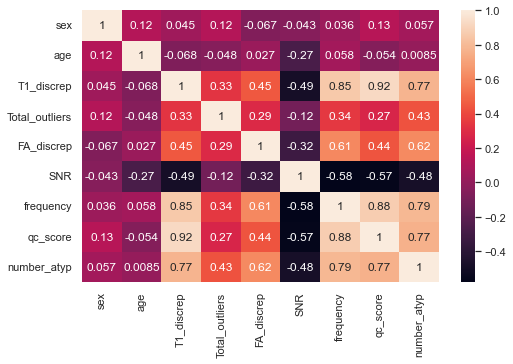

In [44]:
# Apply correlation and visualize
corr_matrix = outlier_norm.corr()
sns.set(rc = {'figure.figsize':(8,5)})
sns.heatmap(corr_matrix, annot=True)

In [45]:
# Normalize data
dataqc_norm = data_qc.copy()
dataqc_norm = (dataqc_norm - dataqc_norm.min()) / (dataqc_norm.max() - dataqc_norm.min()) 

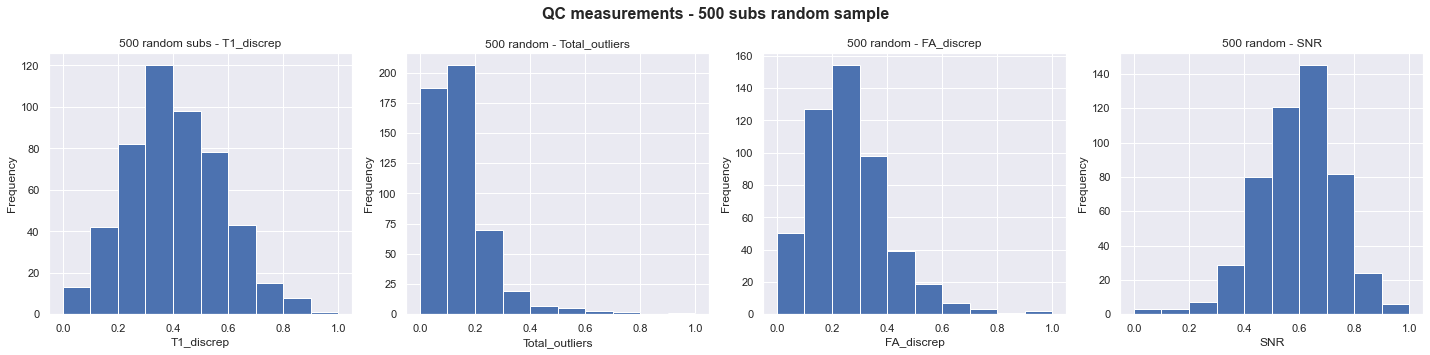

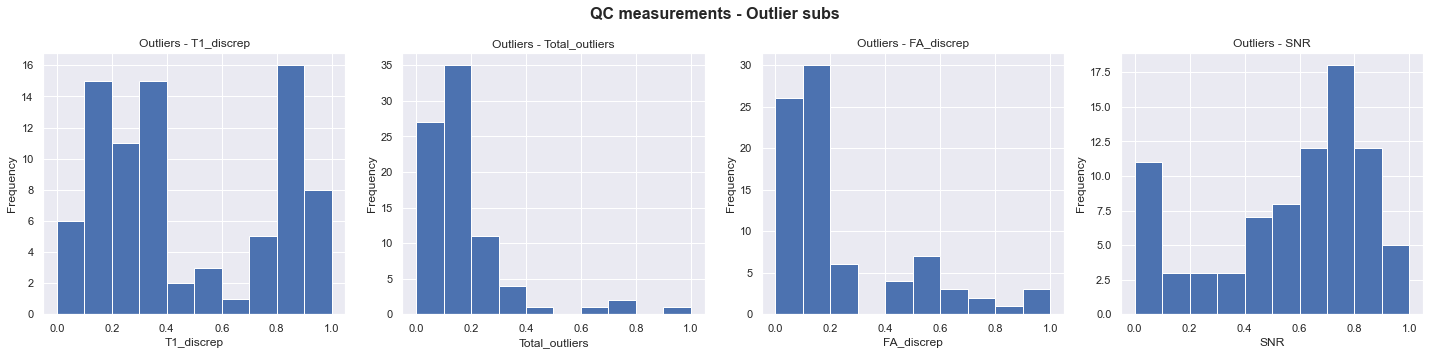

In [46]:
fig1 = plt.figure(figsize=(20, 5))

plt.subplot(1,4,1)
plt.hist(dataqc_norm['T1_discrep'])
plt.xlabel('T1_discrep')
plt.ylabel('Frequency')
plt.title('500 random subs - T1_discrep')

plt.subplot(1,4,2)
plt.hist(dataqc_norm['No_outliers_corrected'])
plt.xlabel('Total_outliers')
plt.ylabel('Frequency')
plt.title('500 random - Total_outliers')

plt.subplot(1,4,3)
plt.hist(dataqc_norm['FA_qc'])
plt.xlabel('FA_discrep')
plt.ylabel('Frequency')
plt.title('500 random - FA_discrep')

plt.subplot(1,4,4)
plt.hist(dataqc_norm['SNR'])
# plt.xlim([0,400])
plt.xlabel('SNR')
plt.ylabel('Frequency')
plt.title('500 random - SNR')

fig1.suptitle('QC measurements - 500 subs random sample',fontweight ="bold", fontsize = 16.0)

fig1.tight_layout(pad = 1)
plt.show()

fig2 = plt.figure(figsize=(20, 5))

plt.subplot(1,4,1)
plt.hist(outlier_norm['T1_discrep'])
plt.xlabel('T1_discrep')
plt.ylabel('Frequency')
plt.title('Outliers - T1_discrep')

plt.subplot(1,4,2)
plt.hist(outlier_norm['Total_outliers'])
plt.xlabel('Total_outliers')
plt.ylabel('Frequency')
plt.title('Outliers - Total_outliers')

plt.subplot(1,4,3)
plt.hist(outlier_norm['FA_discrep'])
plt.xlabel('FA_discrep')
plt.ylabel('Frequency')
plt.title('Outliers - FA_discrep')

plt.subplot(1,4,4)
plt.hist(outlier_norm['SNR'])
# plt.xlim([0,400])
plt.xlabel('SNR')
plt.ylabel('Frequency')
plt.title('Outliers - SNR')

fig2.suptitle('QC measurements - Outlier subs',fontweight ="bold",fontsize = 16.0)

fig2.tight_layout(pad = 1)
plt.show()

In [47]:
outlier_norm

,sex,age,T1_discrep,Total_outliers,FA_discrep,SNR,frequency,qc_score,number_atyp
eid,,,,,,,,,
1326726,1.0,0.172414,0.969626,0.679775,1.000000,0.811161,1.0,1.0,1.000000
4075948,0.0,0.137931,0.987727,0.769663,0.935674,0.858560,1.0,1.0,1.000000
5901699,1.0,1.000000,1.000000,1.000000,0.544248,0.221139,1.0,1.0,1.000000
4663332,0.0,0.413793,0.740818,0.000000,0.458178,0.005660,0.9,1.0,0.666667
6005432,0.0,0.965517,0.775211,0.117978,0.648140,0.036439,0.9,1.0,0.666667
...,...,...,...,...,...,...,...,...,...
4998292,1.0,0.586207,0.304603,0.115169,0.081362,0.468791,0.0,0.0,0.000000
1561680,0.0,0.758621,0.152897,0.039326,0.101097,0.795523,0.0,0.0,0.000000
1829475,0.0,0.758621,0.067844,0.297753,0.084955,0.597679,0.0,0.0,0.000000


### Add outliers QC by artefact type

In [48]:
save_path = '/home/preclineu/ramcir/Desktop/Diffusion/diffusion_nm/outliers_qc.csv'
outliers_qctype = pd.read_csv(save_path, delimiter=';')
# outliers_qctype 
outlier_data_qc = outlier_data.join(outliers_qctype.set_index(outlier_data.index), on='eid',how='left')

In [49]:
outlier_data_qc

,sex,age,T1_discrep,Total_outliers,FA_discrep,SNR,frequency,T1_discrep_outlier,SNR_outlier,Total_outliers_outlier,...,number_atyp,Movement (blurr),EC,FOV top,FOV bottom,Susceptibility,Signal loss,Incidental finding,BET,Ventricles
eid,,,,,,,,,,,,,,,,,,,,,
1326726,1.0,56.0,0.950575,242.0,0.860961,30.431709,11,1.0,0.0,1.0,...,3.0,1,1,1,3,1,1,0,1,1
4075948,0.0,55.0,0.960339,274.0,0.815509,31.991095,11,1.0,0.0,1.0,...,3.0,1,1,1,3,1,1,0,1,1
5901699,1.0,80.0,0.966959,356.0,0.538933,11.020597,11,1.0,0.0,1.0,...,3.0,1,1,1,3,1,1,0,1,1
4663332,0.0,63.0,0.827152,0.0,0.478117,3.931540,10,1.0,0.0,0.0,...,2.0,3,1,1,1,1,3,0,3,1
6005432,0.0,79.0,0.845704,42.0,0.612342,4.944144,10,1.0,0.0,0.0,...,2.0,3,1,1,1,1,2,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4998292,1.0,68.0,0.591851,41.0,0.211864,19.168098,1,0.0,0.0,0.0,...,0.0,1,1,1,1,1,1,1,1,3
1561680,0.0,73.0,0.510018,14.0,0.225809,29.917219,1,0.0,0.0,0.0,...,0.0,1,1,1,1,1,1,1,1,2
1829475,0.0,73.0,0.464139,106.0,0.214403,23.408358,1,0.0,0.0,0.0,...,0.0,1,1,1,1,1,1,1,1,3


In [ ]:
# Normalize data
outlier_norm_qc = outlier_data_qc.copy()
outlier_norm_qc = (outlier_norm_qc - outlier_norm_qc.min()) / (outlier_norm_qc.max() - outlier_norm_qc.min())  
# Remove uninteresting columns
# outlier_norm_qc = outlier_norm_qc.drop(['EC', 'FOV top'], axis=1)
# Apply correlation and visualize
corr_matrix_qc = outlier_norm_qc.corr()
sns.set(rc = {'figure.figsize':(15,10)})
sns.heatmap(corr_matrix_qc, annot=True)

In [51]:
df_idp_outliers
outlier_data_qc_idp = outlier_data_qc.join(df_idp_outliers.set_index(outlier_data_qc.index), on='eid',how='left')

In [ ]:
# Normalize data
outlier_data_qc_idp = outlier_data_qc_idp.copy()
outlier_data_qc_idp = (outlier_data_qc_idp - outlier_data_qc_idp.min()) / (outlier_data_qc_idp.max() - outlier_data_qc_idp.min()) 
# Remove uninteresting columns
# outlier_data_qc_idp = outlier_data_qc_idp.drop(['EC', 'FOV top'], axis=1)
# Apply correlation and visualize
outlier_data_qc_idp = outlier_data_qc_idp.corr()
sns.set(rc = {'figure.figsize':(15,10)})
sns.heatmap(outlier_data_qc_idp, annot=True)

In [67]:
outliers_qctype=outliers_qctype.set_index(outlier_data_qc.index)
df_idp_outliers=df_idp_outliers.set_index(outlier_data_qc.index)

artefact_vs_idp = outliers_qctype.join(df_idp_outliers.set_index(outliers_qctype.index), on='eid',how='left')
artefact_vs_idp = artefact_vs_idp.drop(['EC', 'FOV top','Incidental finding', 'FA_fornix', 'ISOVF_fornix'], axis=1)

In [11]:
outliers_qctype

NameError: name 'outliers_qctype' is not defined

In [65]:
artefact_vs_idp

,Movement (blurr),EC,FOV top,FOV bottom,Susceptibility,Signal loss,Incidental finding,BET,Ventricles,FA_corpus_callosum,...,ICVF_uncinate_right,ICVF_fornix,ICVF_corticospinal_left,ICVF_corticospinal_right,ISOVF_corpus_callosum,ISOVF_uncinate_left,ISOVF_uncinate_right,ISOVF_fornix,ISOVF_corticospinal_left,ISOVF_corticospinal_right
eid,,,,,,,,,,,,,,,,,,,,,
1326726,1,1,1,3,1,1,0,1,1,0,...,1,0,1,1,0,0,0,0,0,0
4075948,1,1,1,3,1,1,0,1,1,0,...,1,0,1,1,0,0,0,0,0,0
5901699,1,1,1,3,1,1,0,1,1,0,...,1,0,1,1,0,0,0,0,0,0
4663332,3,1,1,1,1,3,0,3,1,0,...,0,1,1,1,0,0,1,0,0,0
6005432,3,1,1,1,1,2,0,3,1,0,...,1,1,1,1,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4998292,1,1,1,1,1,1,1,1,3,0,...,0,0,0,0,0,0,0,0,0,0
1561680,1,1,1,1,1,1,1,1,2,0,...,0,0,0,0,0,0,0,0,0,0
1829475,1,1,1,1,1,1,1,1,3,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

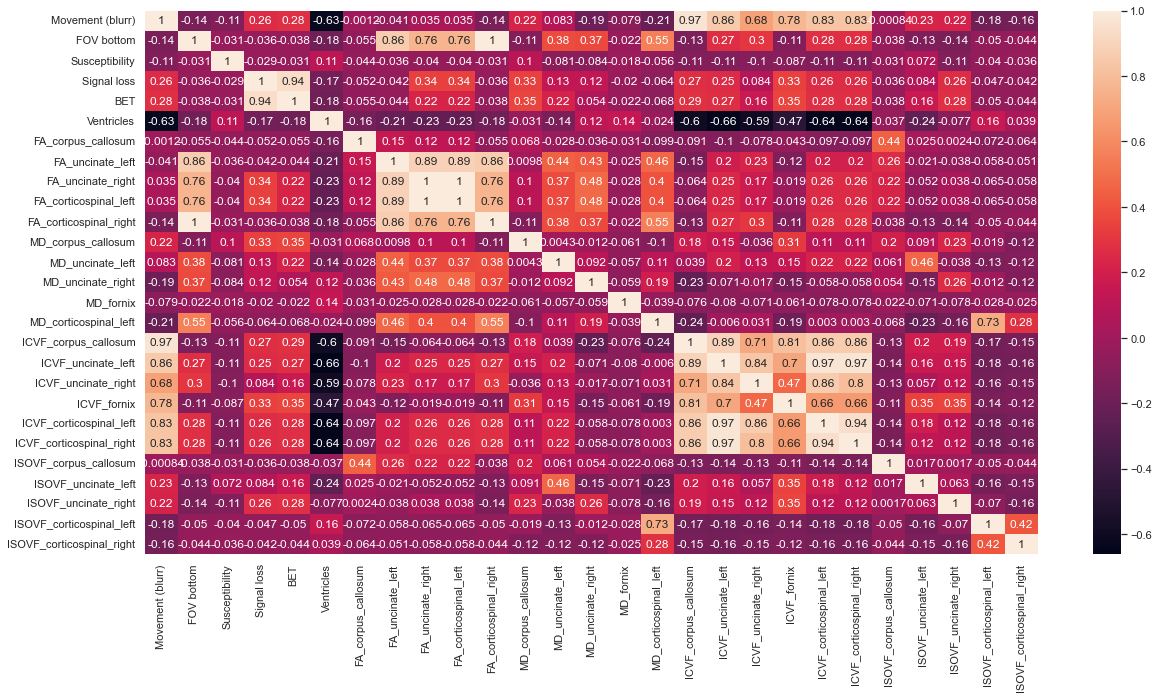

In [69]:
# Normalize data
artefact_vs_idp_copy = artefact_vs_idp.copy()
artefact_vs_idp_copy = (artefact_vs_idp_copy - artefact_vs_idp_copy.min()) / (artefact_vs_idp_copy.max() - artefact_vs_idp_copy.min())  
# Apply correlation and visualize
corr_matrix_qc = artefact_vs_idp_copy.corr()
sns.set(rc = {'figure.figsize':(20,10)})
sns.heatmap(corr_matrix_qc, annot=True)

### Atlas warping 

In [2]:
idp_ids = ['Mean_FA_in_body_of_corpus_callosum_on_FA_skeleton', 
               'Mean_FA _in_uncinate_fasciculus_on_FA_skeleton_left',
               'Mean_FA_in_uncinate_fasciculus_on_FA_skeleton_right',
               'Mean_FA_in_fornix_on_FA_skeleton',
               'Mean_FA_in_corticospinal_tract_on_FA_skeleton_left',
               'Mean_FA_in_corticospinal_tract_on_FA_skeleton_right',
               'Mean_MD_in_body_of_corpus_callosum_on_FA_skeleton', 
               'Mean_MD_in_uncinate_fasciculus_on_FA_skeleton_left',
               'Mean_MD_in_uncinate_fasciculus_on_FA_skeleton_right',
               'Mean_MD_in_fornix_on_FA_skeleton',
               'Mean_MD_in_corticospinal_tract_on_FA_skeleton_left',               
               'Mean_ICVF_in_body_of_corpus_callosum_on_FA_skeleton', 
               'Mean_ICVF _in_uncinate_fasciculus_on_FA_skeleton_left',
               'Mean_ICVF_in_uncinate_fasciculus_on_FA_skeleton_right',
               'Mean_ICVF_in_fornix_on_FA_skeleton',
               'Mean_ICVF_in_corticospinal_tract_on_FA_skeleton_left',
               'Mean_ICVF_in_corticospinal_tract_on_FA_skeleton_right',
               'Mean_ISOVF_in_body_of_corpus_callosum_on_FA_skeleton', 
               'Mean_ISOVF _in_uncinate_fasciculus_on_FA_skeleton_left',
               'Mean_ISOVF_in_uncinate_fasciculus_on_FA_skeleton_right',
               'Mean_ISOVF_in_fornix_on_FA_skeleton',
               'Mean_ISOVF_in_corticospinal_tract_on_FA_skeleton_left',
               'Mean_ISOVF_in_corticospinal_tract_on_FA_skeleton_right']

for idp_num, idp in enumerate(idp_ids):
    # TRAIN DATA #####################################################################################################
        sns.set(style='whitegrid')
        idp_dir = os.path.join(out_dir, idp)
        os.chdir(idp_dir)

        # load the true data points
        yhat_te = load_2d(os.path.join(idp_dir, 'yhat_estimate.txt'))
        s2_te = load_2d(os.path.join(idp_dir, 'ys2_estimate.txt'))
        y_te = load_2d(os.path.join(idp_dir, 'resp_te.txt'))
        idx = range(0, len(X_te))
        y_tr = load_2d(os.path.join(idp_dir, 'resp_tr.txt'))

        # set up the covariates for the dummy data
        print('Making predictions with dummy covariates (for visualisation)')
        yhat, s2 = predict(cov_file_dummy, 
                           alg = 'blr', 
                           respfile = None, 
                           model_path = os.path.join(idp_dir,'Models'), 
                           outputsuffix = '_dummy')

        # load the normative model
        with open(os.path.join(idp_dir,'Models', 'NM_0_0_estimate.pkl'), 'rb') as handle:
            nm = pickle.load(handle) 

        # get the warp and warp parameters
        W = nm.blr.warp
        warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 

        # first, we warp predictions for the true data and compute evaluation metrics
        med_te = W.warp_predictions(np.squeeze(yhat_te), np.squeeze(s2_te), warp_param)[0]
        med_te = med_te[:, np.newaxis]
        print('metrics:', evaluate(y_te, med_te))

        # then, we warp dummy predictions to create the plots
        med, pr_int = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param)

        # extract the different variance components to visualise
        beta, junk1, junk2 = nm.blr._parse_hyps(nm.blr.hyp, X_dummy)
        s2n = 1/beta # variation (aleatoric uncertainty)
        s2s = s2-s2n # modelling uncertainty (epistemic uncertainty)

        # plot the (adjusted) data points
        plt.scatter(df_tr['age'], y_tr, s=4, color=clr, alpha = 1)

        # plot the median of the dummy data
        plt.plot(xx, med, clr)

        # fill the gaps in between the centiles
        junk, pr_int25 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.25,0.75])
        junk, pr_int95 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.05,0.95])
        junk, pr_int99 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.01,0.99])
        plt.fill_between(xx, pr_int25[:,0], pr_int25[:,1], alpha = 0.1,color=clr)
        plt.fill_between(xx, pr_int95[:,0], pr_int95[:,1], alpha = 0.1,color=clr)
        plt.fill_between(xx, pr_int99[:,0], pr_int99[:,1], alpha = 0.1,color=clr)

        # make the width of each centile proportional to the epistemic uncertainty
        junk, pr_int25l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.25,0.75])
        junk, pr_int95l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.05,0.95])
        junk, pr_int99l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.01,0.99])
        junk, pr_int25u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.25,0.75])
        junk, pr_int95u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.05,0.95])
        junk, pr_int99u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.01,0.99])    
        plt.fill_between(xx, pr_int25l[:,0], pr_int25u[:,0], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int95l[:,0], pr_int95u[:,0], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int99l[:,0], pr_int99u[:,0], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int25l[:,1], pr_int25u[:,1], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int95l[:,1], pr_int95u[:,1], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int99l[:,1], pr_int99u[:,1], alpha = 0.3,color=clr)

        # plot actual centile lines
        plt.plot(xx, pr_int25[:,0],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int25[:,1],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int95[:,0],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int95[:,1],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int99[:,0],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int99[:,1],color=clr, linewidth=0.5)

        plt.xlabel('Age')
        plt.ylabel('IDP value') 
        plt.title('Train data: ' + idp)

        plt.xlim((45,85))
        plt.ylim((np.mean(y_te)-10*np.std(y_te)), (np.mean(y_te)+10*np.std(y_te)))

NameError: name 'sns' is not defined